<a href="https://colab.research.google.com/github/nprimavera/Diffusion-Models/blob/main/Project4_V1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Introduction**


In this project, you will implement various agents to perform Behavioral Cloning, including a simple **MLP** agent, a **Conditional Variational Autoencoder (CVAE)** agent, and a **Diffusion Policy** agent.

The assignment is based on the state-based Push-T environment. In this environment, the objective is to push a T-shaped block from various starting poses to a fixed goal pose using a 2D locomotion robot.

The Push-T environment features an observation space of length 5 and an action space of length 2:

*   **Obs:** [agent_pos **(2)**, ob_pos **(2)**, obj_rotation **(1)**]
*   **Action:** $[x, y]$

Here, $x$ and $y$ represent the predicted absolute position of the agent for the next move. And the action is executed using a PD controller.


<div>
<img src="https://github.com/roamlab/mece6616_sp25_project4/blob/main/imgs/pusht.png?raw=true" width="300"/>
</div>

We have preconfigured the model hyperparameters for you, so you will not need to spend time tuning them. We recommend **NOT** modifying these hyperparameters and instead focusing on implementing and refining the training and inference scripts.

You can monitor the loss curves during training and compare them to the expected trends we provided. In this case, you could stop training earlier if it becomes clear that their agent is not converging as expected.

As you successfully complete these scripts for each algorithm, you will observe a consistent improvement in their performance on this manipulation task.




# Project Setup

1. Install required packages

In [1]:
# do NOT change

# Installing required packages
!python3 -m pip install --upgrade pip
!pip3 install scikit-video==1.1.11 zarr==2.12.0 numcodecs==0.15.1 \
pygame==2.6.1 pymunk==6.2.1 gym==0.26.2 shapely==1.8.4 diffusers==0.32.2 \
&> /dev/null # mute output
!pip install numpy==2.0.2 scikit-image==0.23.2 &> /dev/null # mute output

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 MB 9.3 MB/s eta 0:00:00
  Attempting uninstall: pip
    Found existing installation: pip 24.1.2
    Uninstalling pip-24.1.2:
      Successfully uninstalled pip-24.1.2


2. Clone repo from Github

In [2]:
# do NOT change

# After running this cell, the folder 'mece6616_sp25_project4' will show up in the file explorer on the left (click on the folder icon if it's not open)
# It may take a few seconds to appear
!git clone https://github.com/roamlab/mece6616_sp25_project4.git
!mv /content/mece6616_sp25_project4/* /content/
!rm -rf mece6616_sp25_project4

Cloning into 'mece6616_sp25_project4'...
remote: Enumerating objects: 100, done.
remote: Counting objects: 100% (100/100), done.
remote: Compressing objects: 100% (75/75), done.
remote: Total 100 (delta 44), reused 80 (delta 24), pack-reused 0 (from 0)
Receiving objects: 100% (100/100), 324.47 KiB | 3.12 MiB/s, done.
Resolving deltas: 100% (44/44), done.


# Import required packages

In [3]:
import os
import cv2
import math
import gdown
import numpy as np
import zipfile
import pickle
from typing import Union
import collections
from collections import OrderedDict
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
import matplotlib.animation as animation

import torch
import torch.nn as nn
from torch.nn.utils import spectral_norm
from torch.optim.lr_scheduler import CosineAnnealingLR

import pymunk
from pymunk.pygame_util import DrawOptions

from skvideo.io import vwrite
from IPython.display import Video, HTML, clear_output

from PushT import PushTEnv
from dataset import PushTStateDataset, normalize_data, unnormalize_data
from ema import EMAModel
from scheduler import get_cosine_schedule_with_warmup
from util import show_video


# device setup
device = torch.device('cpu')

# activation function setup
activation_dict = nn.ModuleDict(
    {
        "ReLU": nn.ReLU(),
        "ELU": nn.ELU(),
        "GELU": nn.GELU(),
        "Tanh": nn.Tanh(),
        "Mish": nn.Mish(),
        "Identity": nn.Identity(),
        "Softplus": nn.Softplus(),
        "LeakyReLU": nn.LeakyReLU(),
        "Sigmoid": nn.Sigmoid(),
    }
)

pygame 2.6.1 (SDL 2.28.4, Python 3.11.11)
Hello from the pygame community. https://www.pygame.org/contribute.html


# Download Datasets for Behavioral Cloning

In [4]:
# do NOT change

# download demonstration data from Google Drive
dataset_path = "pusht_cchi_v7_replay.zarr.zip"
if not os.path.isfile(dataset_path):
    id = "1KY1InLurpMvJDRb14L9NlXT_fEsCvVUq&confirm=t"
    gdown.download(id=id, output=dataset_path, quiet=False)

# Extract dataset
extract_path = "/content/pusht_cchi_v7_replay.zarr"
if not os.path.exists(extract_path):
    with zipfile.ZipFile(dataset_path, 'r') as zip_ref:
        zip_ref.extractall(extract_path)

Downloading...
From: https://drive.google.com/uc?id=1KY1InLurpMvJDRb14L9NlXT_fEsCvVUq&confirm=t
To: /content/pusht_cchi_v7_replay.zarr.zip
100%|██████████| 31.1M/31.1M [00:00<00:00, 64.2MB/s]


# Push-T Task Environment

Below are some useful APIs provided by the Push-T environment used in this assignment. You may use them for debugging purposes.

1.   **seed(seed):** Set the random seed in the environment
  - Args:
      - seed: the seed to set (int)
  - Returns: None

2.   **reset():** Reset the environment with randomly sampled initial state.
  - Args: None
  - Returns:
      - obs: initial observation (np.array)
      - info: initial hidden parameter values of the environment (dict)

3.   **render(mode):** Render the next frame
  - Args:
      - mode: default as 'rgb_array'
  - Returns: None

4.   **step(action):** Step the environment with the given action.
  - Args:
      - action: action to take (np.array)
  - Returns:          
      - obs: next observation after taking the action (np.array)
      - reward: reward after taking the action (float)
      - terminated: whether the episode is terminated (bool)
      - truncated: whether the episode is truncated (bool)
      - info: hidden parameter values after taking the action (dict)

5.   **set_obs(obs):** Set the certain state to the environment.
  - Args:
      - obs: state to set (torch.Tensor)
  - Returns: None

In [5]:
# do NOT change

# Always ignore `.git` and `.cache/huggingface` folders in commits
IGNORE_GIT_FOLDER_PATTERNS = [
    ".git",
    ".git/*",
    "*/.git",
    "**/.git/**",
    ".cache/huggingface",
    ".cache/huggingface/*",
    "*/.cache/huggingface",
    "**/.cache/huggingface/**",
]

# 0. create env object
env = PushTEnv()

# 1. seed env for initial state.
# Seed 0-200 are used for the demonstration dataset.
env.seed(1000)

# 2. must reset before use
obs, IGNORE_GIT_FOLDER_PATTERNS = env.reset()

# 3. 2D positional action space [0,512]
action = env.action_space.sample()

# 4. Standard gym step method
obs, reward, terminated, truncated, info = env.step(action)

# prints and explains each dimension of the observation and action vectors
with np.printoptions(precision=4, suppress=True, threshold=5):
    print("Obs: ", repr(obs))
    print("Obs:        [agent_x,  agent_y,  block_x,  block_y,    block_angle]")
    print("Action: ", repr(action))
    print("Action:   [target_agent_x, target_agent_y]")

Obs:  array([175.4224, 176.6357, 292.    , 351.    ,   2.9196])
Obs:        [agent_x,  agent_y,  block_x,  block_y,    block_angle]
Action:  array([266.9495, 309.167 ])
Action:   [target_agent_x, target_agent_y]


 # Receding-Horizon Control
Similar to the MPC framework, we apply *receding-horizon control* in this assignment as follows: At each time step $t$, the policy takes the most recent $T_o$ steps of observation data $O_t$ as input, and predicts $T_a$ steps of future actions $A_t$. This stratetgy is illustrated in the Diffusion Policy paper as follows:

<div>
<img src="https://github.com/roamlab/mece6616_sp25_project4/blob/main/imgs/receding.png?raw=true" width="300"/>
</div>

**Important**: In the Push-T task implementation we use, the number of actions predicted by the agent (16) differs from the number of actions actually executed during inference (8).


# Create Dataloader

In [6]:
# do NOT change

# parameters
pred_horizon = 16
obs_horizon = 2
action_horizon = 8
#|o|o|                             observations: 2
#| |a|a|a|a|a|a|a|a|               actions executed: 8
#|p|p|p|p|p|p|p|p|p|p|p|p|p|p|p|p| actions predicted: 16

# create dataset from file
dataset = PushTStateDataset(
    dataset_path=extract_path,
    pred_horizon=pred_horizon,
    obs_horizon=obs_horizon,
    action_horizon=action_horizon
)
# save training data statistics (min, max) for each dim
stats = dataset.stats

# create dataloader
dataloader = torch.utils.data.DataLoader(
    dataset,
    batch_size=256,
    num_workers=1,
    shuffle=True,
    # accelerate cpu-gpu transfer
    pin_memory=True,
    # don't kill worker process afte each epoch
    persistent_workers=True
)

# visualize data in batch
batch = next(iter(dataloader))
print("batch['obs'].shape:", batch['obs'].shape)
print("batch['action'].shape", batch['action'].shape)

batch['obs'].shape: torch.Size([256, 2, 5])
batch['action'].shape torch.Size([256, 16, 2])


# Visualize Demo

In [7]:
# do NOT change

# keep a queue of last 2 steps of observations
# save visualization and rewards
demo_imgs = [env.render(mode='rgb_array')]

# for i in range(batch['obs'].shape[0]):
for i in range(50):
  naction = batch['action'][i]
  nobs = batch['obs'][i]

  obs = unnormalize_data(nobs, stats=stats['obs'])

  # get first observation
  env.set_obs(obs[0])


  # execute action_horizon number of steps
  # without replanning
  for j in range(naction.shape[0]):
      # fetch next action
      action = unnormalize_data(naction[j], stats=stats['action'])
      # stepping env
      obs, reward, done, _, info = env.step(action)
      # saved rendered image
      demo_imgs.append(env.render(mode='rgb_array'))

# create video
vwrite('demo_vis.mp4', demo_imgs, inputdict={'-r': '10'})  # Set frame rate to 10 fps
Video('demo_vis.mp4', embed=True, width=256, height=256)

# **Part I. Vanilla Behavioral Cloning with MLP Agent**

In this setting, we will implement a vanilla Behavioral Cloning agent using a simple Multi-Layer Perceptron (MLP) with residual connection. The MLP agent takes as input an observation sequence of length $T_o$ (set as 2 in the Push-T task), which represents the most recent $T_o$  timesteps of the state data. Based on this input, the agent predicts an action sequence of length $T_a$ (set as 16 in the Push-T task), which corresponds to the next $T_a$ steps the agent intends to take in the environment.

Mathematically, the policy is represented as: $\pi(a_{t:t+T_a} \mid o_{t-T_o:t})$

<div>
<img src="https://github.com/roamlab/mece6616_sp25_project4/blob/main/imgs/mlp_agent.png?raw=true" width="400"/>
</div>

# Residual MLP Model


In [8]:
# do NOT change

class TwoLayerPreActivationResNetLinear(nn.Module):
    def __init__(
        self,
        hidden_dim,
        activation_type="Mish",
        use_layernorm=False,
    ):
        super().__init__()
        self.l1 = nn.Linear(hidden_dim, hidden_dim)
        self.l2 = nn.Linear(hidden_dim, hidden_dim)
        self.act = activation_dict[activation_type]
        if use_layernorm:
            self.norm1 = nn.LayerNorm(hidden_dim, eps=1e-06)
            self.norm2 = nn.LayerNorm(hidden_dim, eps=1e-06)

    def forward(self, x):
        x_input = x
        if hasattr(self, "norm1"):
            x = self.norm1(x)
        x = self.l1(self.act(x))
        if hasattr(self, "norm2"):
            x = self.norm2(x)
        x = self.l2(self.act(x))
        return x + x_input


class ResidualMLP(nn.Module):
    """
    Simple multi layer perceptron network with residual connections for
    benchmarking the performance of different networks. The resiudal layers
    are based on the IBC paper implementation, which uses 2 residual lalyers
    with pre-actication with or without dropout and normalization.
    """

    def __init__(
        self,
        dim_list,
        activation_type="Mish",
        out_activation_type="Identity",
        use_layernorm=False,
    ):
        super(ResidualMLP, self).__init__()
        hidden_dim = dim_list[1]
        num_hidden_layers = len(dim_list) - 3
        assert num_hidden_layers % 2 == 0
        self.layers = nn.ModuleList([nn.Linear(dim_list[0], hidden_dim)])
        self.layers.extend(
            [
                TwoLayerPreActivationResNetLinear(
                    hidden_dim=hidden_dim,
                    activation_type=activation_type,
                    use_layernorm=use_layernorm,
                )
                for _ in range(1, num_hidden_layers, 2)
            ]
        )
        self.layers.append(nn.Linear(hidden_dim, dim_list[-1]))
        self.layers.append(activation_dict[out_activation_type])

    def forward(self, x):
        for _, layer in enumerate(self.layers):
            x = layer(x)
        return x

# **Q1.1**: Complete the ***mlp_dim_list***

**Hints:**
1.   The ***mlp_dim_list*** serves as the dimension list of the ResidualMLP agent.
2.   The input dimension corresponds to the length of the flattened observation.
3.   The output dimension corresponds to the length of the flattened predicted action.
4.   Use the fixed ***mlp_hidden_dim*** as the hidden layer.

In [13]:
"""
Parameters:
  - pred_horizon = 16
  - obs_horizon = 2
  - action_horizon = 8
"""

# observation and action dimensions corrsponding to the output of PushTEnv
obs_dim = 5
action_dim = 2

# create MLP agent (do NOT change!)
mlp_hidden_dim = [256, 256, 256, 256, 256]

# TODO: Complete the dimension list 'mlp_dim_list' of the MLP model
################# Start of your code #################


# dimension list of the ResidualMLP agent - [2*5, mlp_hidden_dim, 16*2] = [10, 256, 256, 256, 256, 256, 32]
mlp_dim_list = [obs_horizon * obs_dim] + mlp_hidden_dim + [pred_horizon * action_dim]


################## End of your code ##################

mlp_agent = ResidualMLP(
    dim_list=mlp_dim_list,
    activation_type="Mish",
    out_activation_type="Identity",
    use_layernorm=True,
)

# device transfer
mlp_agent.to(device)

# example inputs
dummy_obs = torch.zeros((1, obs_horizon, obs_dim), device=device)

# example outputs
dummy_pred_action = mlp_agent(dummy_obs.flatten(start_dim=1)).view(
    -1, pred_horizon, action_dim
)
print("Predicted action chunk shape:", dummy_pred_action.shape)

Predicted action chunk shape: torch.Size([1, 16, 2])


# Test the MLP Agent

In [15]:
# verify the agent output
assert dummy_pred_action.shape == torch.Size([1, 16, 2]), \
"Error: The `mlp_dim_list` is not set correctly!"

# **Q1.2:** Complete the Model Training Script.

**Hints:**

1.   Compute the **Mean Squared Error (MSE)** loss between the predicted actions and the ground truth actions.
2.   Flatten the observation sequence before passing it to the model.
3.   The prefix 'n' in nobs and naction stands for 'normalized', as the agent takes normalized obs sequences as input and predict normalized action sequences. You do not need to handle normalization, as it has already been applied.

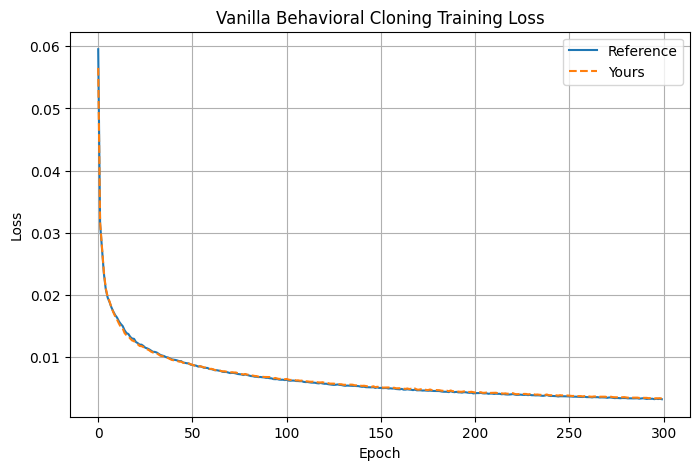

In [16]:
# Model Training

# load expected losses for dubugging
with open('losses/expected_mlp_loss.pkl', 'rb') as f:
    expected_mlp_losses = pickle.load(f)

# set seed (do NOT change!)
env.seed(1)

# Training epochs (do NOT change!)
num_epochs = 300

# Standard ADAM optimizer (do NOT change!)
optimizer = torch.optim.AdamW(
    params=mlp_agent.parameters(),
    lr=1e-4,
)

# Cosine LR scheduler (do NOT change!)
lr_scheduler = CosineAnnealingLR(optimizer, T_max=1000, eta_min=0.0)

# MSE loss
criterion = nn.MSELoss()

# log all epoch losses for plotting
mlp_epoch_losses = []

with tqdm(range(num_epochs), desc='Epoch') as tglobal:
    # epoch loop
    for epoch_idx in tglobal:
        epoch_loss = list()
        # batch loop
        with tqdm(dataloader, desc='Batch', leave=False) as tepoch:
            for nbatch in tepoch:
                # data normalized in dataset
                # device transfer
                nobs = nbatch['obs'].to(device)
                naction = nbatch['action'].to(device)
                B = nobs.shape[0]

                # truncate obs
                # (B, obs_horizon, obs_dim)
                obs_cond = nobs[:, :obs_horizon, :]

                # TODO: compute the MSE loss for behavioral cloning
                ################# Start of your code #################


                # Flatten observations
                flattened_obs = obs_cond.flatten(start_dim=1) # Shape: (B, obs_horizon * obs_dim) = (nobs.shape[0], 2 * 5) = (B, 10)

                # Forward pass: predict actions
                pred_action = mlp_agent(flattened_obs)  # Shape: (B, pred_horizon * action_dim) = (nobs.shape[0], 16 * 2) = (B, 32)

                # Reshape predicted actions (output) to (B, pred_horizon, action_dim) so they are compatible with naction
                pred_action = pred_action.view(B, pred_horizon, action_dim)  # Shape: (B, pred_horizon, action_dim) = (nobs.shape[0], 16, 2) = (B, 16, 2)

                # Compute MSE loss b/w predicted actions and normalized actions
                loss = criterion(pred_action, naction)


                ################## End of your code ##################

                # optimize
                loss.backward()
                optimizer.step()
                optimizer.zero_grad()

                # logging
                loss_cpu = loss.item()
                epoch_loss.append(loss_cpu)
                tepoch.set_postfix(loss=loss_cpu)

        # step scheduler
        lr_scheduler.step()

        # update progress bar
        tglobal.set_postfix(loss=np.mean(epoch_loss))

        # upate the loss buffer
        mean_loss = np.mean(epoch_loss)
        mlp_epoch_losses.append(mean_loss)

        # Live update plot
        clear_output(wait=True)
        plt.clf()
        plt.close()
        plt.figure(figsize=(8, 5))
        plt.plot(expected_mlp_losses, label='Reference')
        plt.plot(mlp_epoch_losses, linestyle="--", label='Yours')
        plt.xlabel('Epoch')
        plt.ylabel('Loss')
        plt.title('Vanilla Behavioral Cloning Training Loss')
        plt.legend()
        plt.grid(True)
        plt.show()

# **Q1.3:** Complete the Model Inference Function.

**Hints:**

1.   Disable Torch gradients during inference.
2.   Assign the model prediction to the parameter ***naction***, ensuring it has the shape (batch_size, pred_horizon, action_dim).

In [17]:
# Model Inference

def mlp_inference(
        model,
        batch_size,
        nobs,
        pred_horizon,
        action_dim,
    ):
    """
      MLP agent Inference Function
      Args:
          model: MLP agent
          batch_size: size of the current batch
          nobs: normalized obs
          pred_horizon: horizon for predicted actions
          action_dim: action dimension

      Returns:
          naction: predicted normalized action sequence
    """
    # TODO: predict action sequence
    # `naction` shape: (batch_size, pred_horizon, action_dim)
    ################# Start of your code #################


    with torch.no_grad():
        # Flatten observation: (batch_size, obs_horizon * obs_dim) = (batch_size, 2 * 5) = (batch_size, 10)
        nobs_flat = nobs.view(batch_size, -1)

        # Run model forward pass
        pred_action = model(nobs_flat)  # Shape: (batch_size, pred_horizon * action_dim) = (batch_size, 16 * 2) = (batch_size, 32)

        # Reshape to (batch_size, pred_horizon, action_dim) = (batch_size, 16, 2)
        naction = pred_action.view(batch_size, pred_horizon, action_dim)  # Shape: (batch_size, 16, 2)

    # return naction - (batch_size, 16, 2)
    return naction


    ################## End of your code ##################


# limit enviornment interaction to 500 steps before termination (do NOT change!)
max_steps = 500
env = PushTEnv()

# set seed (do NOT change!)
env.seed(1)

# get first observation
obs, info = env.reset()

# keep a queue of last 2 steps of observations
obs_deque = collections.deque(
    [obs] * obs_horizon, maxlen=obs_horizon)
# save visualization and rewards
imgs = [env.render(mode='rgb_array')]
rewards = list()
done = False
step_idx = 0

with tqdm(total=max_steps, desc="Eval PushTStateEnv") as pbar:
    while not done:
        B = 1
        # stack the last obs_horizon (2) number of observations
        obs_seq = np.stack(obs_deque)
        # normalize observation
        nobs = normalize_data(obs_seq, stats=stats['obs'])
        # device transfer
        nobs = torch.from_numpy(nobs).to(device, dtype=torch.float32)

        # predict the next action sequence
        naction = mlp_inference(
            model=mlp_agent,
            batch_size=B,
            nobs=nobs,
            pred_horizon=pred_horizon,
            action_dim=action_dim,
        )

        # unnormalize action
        naction = naction.detach().to('cpu').numpy()
        # (pred_horizon, action_dim)
        naction = naction[0]
        action_pred = unnormalize_data(naction, stats=stats['action'])

        # only take action_horizon number of actions
        start = obs_horizon - 1
        end = start + action_horizon
        # (action_horizon, action_dim)
        action = action_pred[start: end, :]

        # execute action_horizon number of steps
        # without replanning
        for i in range(len(action)):
            # stepping env
            obs, reward, done, _, info = env.step(action[i])
            # save observations
            obs_deque.append(obs)
            #and reward/vis
            rewards.append(reward)
            imgs.append(env.render(mode='rgb_array'))

            # update progress bar
            step_idx += 1
            pbar.update(1)
            pbar.set_postfix(reward=reward)
            if step_idx > max_steps:
                done = True
            if done:
                break

# print out the maximum target coverage
print('Score: ', max(rewards))

# visualize
from IPython.display import Video
vwrite('mlp_vis.mp4', imgs)
Video('mlp_vis.mp4', embed=True, width=256, height=256)

Eval PushTStateEnv:   0%|          | 0/500 [00:00<?, ?it/s]

Score:  0.6198301419990233


# **Grading**

In [18]:
# do NOT change

from score import score_part1

# grading
score_part1(
    env,
    mlp_inference,
    mlp_agent,
    obs_horizon,
    action_dim,
    pred_horizon,
    action_horizon,
    max_steps,
    stats,
    device
)

# visualize the rollouts
show_video("mlp_combined_vis.mp4")

Eval PushTStateEnv iter:0:   0%|          | 0/500 [00:00<?, ?it/s]

Score:  0.5926180819488444


Eval PushTStateEnv iter:1:   0%|          | 0/500 [00:00<?, ?it/s]

Score:  0.6198301419990233


Eval PushTStateEnv iter:2:   0%|          | 0/500 [00:00<?, ?it/s]

Score:  0.0


Eval PushTStateEnv iter:3:   0%|          | 0/500 [00:00<?, ?it/s]

Score:  0.0


Eval PushTStateEnv iter:4:   0%|          | 0/500 [00:00<?, ?it/s]

Score:  0.9250421033969085


Eval PushTStateEnv iter:5:   0%|          | 0/500 [00:00<?, ?it/s]

Score:  0.9892081599836929


Eval PushTStateEnv iter:6:   0%|          | 0/500 [00:00<?, ?it/s]

Score:  0.9449340310450572


Eval PushTStateEnv iter:7:   0%|          | 0/500 [00:00<?, ?it/s]

Score:  0.9675662459820034


Eval PushTStateEnv iter:8:   0%|          | 0/500 [00:00<?, ?it/s]

Score:  0.9493804450907326


Eval PushTStateEnv iter:9:   0%|          | 0/500 [00:00<?, ?it/s]

Score:  1.0

---
Part I Average Score: 0.6988579209446262
Part I Grade: 0.70 / 0.60 * 5 = 5.00
Video saved successfully!


# **Part II. Behavioral Cloning with CVAE Agent**

In the second part, we frame behavioral cloning as a conditional generative modeling task, where the goal is to generate action sequences conditioned on observed states. To achieve this, we adopt a **Conditional Variational Autoencoder (CVAE)** agent, which consists of two components: an encoder and a decoder.

The CVAE encoder is used only during training. It takes as input the current observation sequence $o_{t-T_o:t}$ and the corresponding expert action sequence $\bar{a}_{t:t+T_a}$, and outputs the mean and variance of a latent “style” variable $z$. This latent variable captures variations in the demonstrated behavior and is modeled as a multivariate diagonal Gaussian.

To regularize the latent space, we apply a **KL divergence loss** that encourages the distribution of $z$ to match a standard normal distribution $N(0, I)$. This helps prevent the latent representation from collapsing to deterministic values and enables meaningful sampling at inference time. The encoder is discarded during testing.

The CVAE decoder serves as the actual policy. It conditions on both the latent variable $z$ and the current observation sequence $o_{t-T_o:t}$ to predict the action sequence $a_{t:t+T_a}$. At test time, we typically set $z=0$ to perform deterministic decoding.


Mathematically,

*   **CVAE Encoder:** $q_{\phi}(z \mid \bar{a}_{t:t+T_a}, o_{t-T_o:t})$
*   **CVAE Decoder:** $\pi_{\theta}(a_{t:t+T_a} \mid o_{t-T_o:t}, z)$

<div>
<img src="https://github.com/roamlab/mece6616_sp25_project4/blob/main/imgs/cvae_agent.png?raw=true" width="600"/>
</div>


# MLP Backbone Model

In [ ]:
# do NOT change

class MLP(nn.Module):
    def __init__(
        self,
        dim_list=[256, 256, 256],
        append_dim=0,
        append_layers=None,
        activation_type="Tanh",
        out_activation_type="Identity",
        use_layernorm=False,
    ):
        super(MLP, self).__init__()

        # Construct module list: if use `Python List`, the modules are not
        # added to computation graph. Instead, we should use `nn.ModuleList()`.
        self.moduleList = nn.ModuleList()
        self.append_layers = append_layers
        num_layer = len(dim_list) - 1
        for idx in range(num_layer):
            i_dim = dim_list[idx]
            o_dim = dim_list[idx + 1]
            if append_dim > 0 and idx in append_layers:
                i_dim += append_dim

            linear_layer = nn.Linear(i_dim, o_dim)
            if idx == num_layer - 1:
                module = nn.Sequential(
                    OrderedDict(
                        [
                            ("linear_1", linear_layer),
                            ("act_1", activation_dict[out_activation_type]),
                        ]
                    )
                )
            else:
                if use_layernorm:
                    module = nn.Sequential(
                        OrderedDict(
                            [
                                ("linear_1", linear_layer),
                                ("norm_1", nn.LayerNorm(o_dim)),
                                ("act_1", activation_dict[activation_type]),
                            ]
                        )
                    )
                else:
                    module = nn.Sequential(
                        OrderedDict(
                            [
                                ("linear_1", linear_layer),
                                ("act_1", activation_dict[activation_type]),
                            ]
                        )
                    )
            self.moduleList.append(module)

    def forward(self, x, append=None):
        for layer_ind, m in enumerate(self.moduleList):
            if append is not None and layer_ind in self.append_layers:
                x = torch.cat((x, append), dim=-1)
            x = m(x)
        return x

# Encoder and Decoder

In [ ]:
# do NOT change

class Encoder(nn.Module):
    def __init__(
        self,
        dim_list,
        obs_dim,
        obs_horizon,
        action_dim,
        pred_horizon,
        latent_dim,
    ):
        super(Encoder, self).__init__()
        # compute the input dim (obs + action)
        input_dim = obs_horizon * obs_dim + pred_horizon * action_dim
        dim_list = [input_dim] + dim_list
        out_size = dim_list[-1]

        # create MLP model
        self.fc1 = MLP(dim_list=dim_list, use_layernorm=False)
        # create output layer
        self.fc_mu = nn.Linear(out_size, latent_dim)
        self.fc_logvar = nn.Linear(out_size, latent_dim)

    def forward(self, obs, action):
        x = torch.cat([obs, action], dim=1)
        x = self.fc1(x)
        mu = self.fc_mu(x)
        logvar = self.fc_logvar(x)
        return mu, logvar


class Decoder(nn.Module):
    def __init__(
        self,
        dim_list,
        obs_dim,
        obs_horizon,
        action_dim,
        pred_horizon,
        latent_dim,
    ):
        super(Decoder, self).__init__()
        # compute the input dim (obs + latent)
        input_dim = obs_horizon * obs_dim + latent_dim
        dim_list = [input_dim] + dim_list
        out_size = dim_list[-1]

        # create MLP model
        self.fc1 = MLP(dim_list=dim_list, use_layernorm=False)
        # create output layer
        self.fc2 = nn.Linear(out_size, action_dim * pred_horizon)

    def forward(self, obs, z):
        x = torch.cat([obs, z], dim=1)
        x = self.fc1(x)
        action = self.fc2(x)
        return action

# **Q2.1:** Complete the Functions in CVAEAgent.

**Hints:**

1.   Use CVAE Encoder to predict the mean and variance of $z$ during training.
2.   Use only CVAE Decoder and set $z$ as $0$ during inference.

**Note:**

The *reparameterize()* function serves to separate the randomness from the parameters (mu and logvar) so that gradients can still flow through mu and logvar when computing the loss.

In [ ]:
class CVAEAgent(nn.Module):
    def __init__(
        self,
        encoder_dim_list,
        decoder_dim_list,
        obs_dim,
        obs_horizon,
        action_dim,
        pred_horizon,
        latent_dim,
    ):
        super(CVAEAgent, self).__init__()
        self.latent_dim = latent_dim

        # create encoder and decoder
        self.encoder = Encoder(
            encoder_dim_list,
            obs_dim,
            obs_horizon,
            action_dim,
            pred_horizon,
            latent_dim
        )
        self.decoder = Decoder(
            decoder_dim_list,
            obs_dim,
            obs_horizon,
            action_dim,
            pred_horizon,
            latent_dim)

    def reparameterize(self, mu, logvar):
        # Enables backpropagation through a stochastic sampling process
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mu + eps * std

    def sample_action(self, obs):
        # TODO: complete the inference function
        # Hint:
        # 1. Set embedding z as 0 during the inference time
        # 2. Only return action sequence
        ################# Start of your code #################





        ################## End of your code ##################

    def forward(self, obs, action):
        # TODO: complete the forward function for training
        # Hint:
        # 1. Call reparameterize() function to enable backpropagation
        # 2. Include mu and logvar of embedding z in the return
        #    to compute the KL loss
        ################# Start of your code #################





        ################## End of your code ##################

# Test the CVAE Agent

In [ ]:
# do NOT change

# observation and action dimensions corrsponding to
# the output of PushTEnv
obs_dim = 5
action_dim = 2

# create CVAE agent (do NOT change!)
encoder_dim_list = [256, 512, 1024, 512, 256]
decoder_dim_list = [256, 512, 1024, 512, 256]

cvae_agent = CVAEAgent(
    encoder_dim_list=encoder_dim_list,
    decoder_dim_list=decoder_dim_list,
    obs_dim=obs_dim,
    obs_horizon=obs_horizon,
    action_dim=action_dim,
    pred_horizon=pred_horizon,
    latent_dim=32,
)

# device transfer
cvae_agent.to(device)

# example inputs
dummy_obs = torch.zeros((1, obs_horizon, obs_dim), device=device)

# example outputs
dummy_pred_action = cvae_agent.sample_action(dummy_obs.flatten(start_dim=1)).view(
    -1, pred_horizon, action_dim
)
print("Predicted action chunk shape:", dummy_pred_action.shape)

# verify the agent output
assert dummy_pred_action.shape == torch.Size([1, 16, 2]), \
"Error: The output shape of the CVAEAgent was wrong!"

# **Q2.2**: Implement the KL Divergence Loss

**KL Loss:**

$L_{KL} = D_{\text{KL}}\left( q_{\phi}(z \mid a_{t:t+T_a}, o_{t-T_o:t}) \,\|\, N(0, I) \right)$, where $q_{\phi}$ is the CVAE encoder.


**Hints:**

The KL Divergence is defined as:

*   **Discrete case**: $D_{\text{KL}}(P \,\|\, Q) = \sum_{x} P(x) \log \left( \frac{P(x)}{Q(x)}\right)$
*   **Continuous case**: $D_{\text{KL}}(P \,\|\, Q) = \int_{-\infty}^{\infty} p(x) \log \left( \frac{p(x)}{q(x)} \right) dx$

In this assignment, we only deal with the continuous case since the latent variable $z$ is continuous.


Let $P = N(\mu, \sigma^2)$, and $Q = N(0, I)$. The KL Divergence could be simplified as:

$$
D_{\text{KL}}(P \parallel Q) = -\frac{1}{2} \sum_{i=1}^{d} \left( 1 + \log \sigma_i^2 - \mu_i^2 - \sigma_i^2 \right)
$$

In [ ]:
# KL weight (do NOT change!)
beta = 10.0

# KL loss
def kl_divergence(mu, logvar):
    # TODO: complete the function to compute the KL divergence
    ################# Start of your code #################




    # return kl_loss
    ################## End of your code ##################

# Verify Your Implementation of the KL Divergence

In [ ]:
# do NOT change!

from score import test_kl_divergence

test_kl_divergence(kl_divergence)

# **Q2.3:** Complete the CVAE Model Training Script.

**Hints:**

1.   $L = L_{BC} + \beta L_{KL}$
2.   Flatten the observation sequence before passing it to the model.

In [ ]:
# load expected losses for dubugging
with open('losses/expected_cvae_loss.pkl', 'rb') as f:
    expected_cvae_losses = pickle.load(f)

# set seed (do NOT change!)
env.seed(1)

# Training epochs (do NOT change!)
num_epochs = 300

# Standard ADAM optimizer (do NOT change!)
optimizer = torch.optim.AdamW(
    params=cvae_agent.parameters(),
    lr=3e-4,
)

# Cosine LR scheduler (do NOT change!)
lr_scheduler = CosineAnnealingLR(optimizer, T_max=1000, eta_min=0.0)

# MSE loss
mse_criterion = nn.MSELoss()

# log all epoch losses for plotting
cvae_epoch_losses = []

with tqdm(range(num_epochs), desc='Epoch') as tglobal:
    # epoch loop
    for epoch_idx in tglobal:
        epoch_loss = list()
        # batch loop
        with tqdm(dataloader, desc='Batch', leave=False) as tepoch:
            for nbatch in tepoch:
                # data normalized in dataset
                # device transfer
                nobs = nbatch['obs'].to(device)
                naction = nbatch['action'].to(device)
                B = nobs.shape[0]

                # truncate obs
                # (B, obs_horizon, obs_dim)
                obs_cond = nobs[:, :obs_horizon, :]

                # TODO: compute the loss for CVAE agent
                # loss = mse_loss + beta * kl_loss
                # Call mse_criterion() to compute the BC loss
                # Call kl_divergence() to compute the KL loss
                ################# Start of your code #################





                ################## End of your code ##################

                # optimize
                loss.backward()
                optimizer.step()
                optimizer.zero_grad()

                # logging
                loss_cpu = loss.item()
                epoch_loss.append(loss_cpu)
                tepoch.set_postfix(loss=loss_cpu)

        # step scheduler
        lr_scheduler.step()

        # update progress bar
        tglobal.set_postfix(loss=np.mean(epoch_loss))

        # upate the loss buffer
        mean_loss = np.mean(epoch_loss)
        cvae_epoch_losses.append(mean_loss)

        # Live update plot
        clear_output(wait=True)
        plt.clf()
        plt.close()
        plt.figure(figsize=(8, 5))
        plt.plot(expected_cvae_losses, label='Reference')
        plt.plot(cvae_epoch_losses, linestyle="--", label='Yours')
        plt.xlabel('Epoch')
        plt.ylabel('Loss')
        plt.title('CVAE Behavioral Cloning Training Loss')
        plt.legend()
        plt.grid(True)
        plt.show()


# **Q2.4:** Complete the CVAE Model Inference Function.

**Hints:**

1.   Disable Torch gradients during inference.
2.   Assign the model prediction to the parameter ***naction***, ensuring it has the shape (batch_size, pred_horizon, action_dim).

In [ ]:
# Inference

def cvae_inference(
        model,
        batch_size,
        nobs,
        pred_horizon,
        action_dim,
    ):
    """
      CVAE agent Inference Function
      Args:
          model: CVAE agent
          batch_size: size of the current batch
          nobs: normalized obs
          pred_horizon: horizon for predicted actions
          action_dim: action dimension

      Returns:
          naction: predicted normalized action sequence
    """
    # TODO: predict action sequence
    # `naction` shape: (batch_size, pred_horizon, action_dim)
    ################# Start of your code #################





    # return naction
    ################## End of your code ##################


# limit enviornment interaction to 500 steps before termination (do NOT change!)
max_steps = 500
env = PushTEnv()

# set seed (do NOT change!)
env.seed(1)

# get first observation
obs, info = env.reset()

# keep a queue of last 2 steps of observations
obs_deque = collections.deque(
    [obs] * obs_horizon, maxlen=obs_horizon)
# save visualization and rewards
imgs = [env.render(mode='rgb_array')]
rewards = list()
done = False
step_idx = 0

with tqdm(total=max_steps, desc="Eval PushTStateEnv") as pbar:
    while not done:
        B = 1
        # stack the last obs_horizon (2) number of observations
        obs_seq = np.stack(obs_deque)
        # normalize observation
        nobs = normalize_data(obs_seq, stats=stats['obs'])
        # device transfer
        nobs = torch.from_numpy(nobs).to(device, dtype=torch.float32)

        # predict the next action sequence
        naction = cvae_inference(
            model=cvae_agent,
            batch_size=B,
            nobs=nobs,
            pred_horizon=pred_horizon,
            action_dim=action_dim,
        )

        # unnormalize action
        naction = naction.detach().to('cpu').numpy()
        # (B, pred_horizon, action_dim)
        naction = naction[0]
        action_pred = unnormalize_data(naction, stats=stats['action'])

        # only take action_horizon number of actions
        start = obs_horizon - 1
        end = start + action_horizon
        # (action_horizon, action_dim)
        action = action_pred[start:end,:]

        # execute action_horizon number of steps
        # without replanning
        for i in range(len(action)):
            # stepping env
            obs, reward, done, _, info = env.step(action[i])
            # save observations
            obs_deque.append(obs)
            #and reward/vis
            rewards.append(reward)
            imgs.append(env.render(mode='rgb_array'))

            # update progress bar
            step_idx += 1
            pbar.update(1)
            pbar.set_postfix(reward=reward)
            if step_idx > max_steps:
                done = True
            if done:
                break

# print out the maximum target coverage
print('Score: ', max(rewards))

# visualize
from IPython.display import Video
vwrite('cvae_vis.mp4', imgs)
Video('cvae_vis.mp4', embed=True, width=256, height=256)

# **Grading**

In [ ]:
# do NOT change

from score import score_part2

# grading
score_part2(
    env,
    cvae_inference,
    cvae_agent,
    obs_horizon,
    action_dim,
    pred_horizon,
    action_horizon,
    max_steps,
    stats,
    device
)

# visualize the rollouts
show_video("cvae_combined_vis.mp4")

# **Part III. Behavioral Cloning with Diffusion Policy**

In this section, we will focus on implementing the Denoising Diffusion Probabilistic Model (DDPM) and perform Behavioral Cloning based on the Diffusion Policy, as introduced in the guest lecture by Zhanpeng He.

You will be provided with a pre-implemented U-Net architecture and fixed hyperparameters that serve as the noise prediction network.

Your task will be to implement the key components of DDPM:
1. Cosine noise schedule
2. Forward diffusion process
3. Backward denoising process

In [ ]:
# do NOT change

class SinusoidalPosEmb(nn.Module):
    def __init__(self, dim):
        super().__init__()
        self.dim = dim

    def forward(self, x):
        device = x.device
        half_dim = self.dim // 2
        emb = math.log(10000) / (half_dim - 1)
        emb = torch.exp(torch.arange(half_dim, device=device) * -emb)
        emb = x[:, None] * emb[None, :]
        emb = torch.cat((emb.sin(), emb.cos()), dim=-1)
        return emb


class Downsample1d(nn.Module):
    def __init__(self, dim):
        super().__init__()
        self.conv = nn.Conv1d(dim, dim, 3, 2, 1)

    def forward(self, x):
        return self.conv(x)

class Upsample1d(nn.Module):
    def __init__(self, dim):
        super().__init__()
        self.conv = nn.ConvTranspose1d(dim, dim, 4, 2, 1)

    def forward(self, x):
        return self.conv(x)


class Conv1dBlock(nn.Module):
    '''
        Conv1d --> GroupNorm --> Mish
    '''

    def __init__(self, inp_channels, out_channels, kernel_size, n_groups=8):
        super().__init__()

        self.block = nn.Sequential(
            nn.Conv1d(inp_channels, out_channels, kernel_size, padding=kernel_size // 2),
            nn.GroupNorm(n_groups, out_channels),
            nn.Mish(),
        )

    def forward(self, x):
        return self.block(x)


class ConditionalResidualBlock1D(nn.Module):
    def __init__(self,
            in_channels,
            out_channels,
            cond_dim,
            kernel_size=3,
            n_groups=8):
        super().__init__()

        self.blocks = nn.ModuleList([
            Conv1dBlock(in_channels, out_channels, kernel_size, n_groups=n_groups),
            Conv1dBlock(out_channels, out_channels, kernel_size, n_groups=n_groups),
        ])

        # FiLM modulation https://arxiv.org/abs/1709.07871
        # predicts per-channel scale and bias
        cond_channels = out_channels * 2
        self.out_channels = out_channels
        self.cond_encoder = nn.Sequential(
            nn.Mish(),
            nn.Linear(cond_dim, cond_channels),
            nn.Unflatten(-1, (-1, 1))
        )

        # make sure dimensions compatible
        self.residual_conv = nn.Conv1d(in_channels, out_channels, 1) \
            if in_channels != out_channels else nn.Identity()

    def forward(self, x, cond):
        '''
            x : [ batch_size x in_channels x horizon ]
            cond : [ batch_size x cond_dim]

            returns:
            out : [ batch_size x out_channels x horizon ]
        '''
        out = self.blocks[0](x)
        embed = self.cond_encoder(cond)

        embed = embed.reshape(
            embed.shape[0], 2, self.out_channels, 1)
        scale = embed[:,0,...]
        bias = embed[:,1,...]
        out = scale * out + bias

        out = self.blocks[1](out)
        out = out + self.residual_conv(x)
        return out


class ConditionalUnet1D(nn.Module):
    def __init__(self,
        input_dim,
        global_cond_dim,
        diffusion_step_embed_dim=256,
        down_dims=[256,512,1024],
        kernel_size=5,
        n_groups=8
        ):
        """
        input_dim: Dim of actions.
        global_cond_dim: Dim of global conditioning applied with FiLM
          in addition to diffusion step embedding. This is usually obs_horizon * obs_dim
        diffusion_step_embed_dim: Size of positional encoding for diffusion iteration k
        down_dims: Channel size for each UNet level.
          The length of this array determines numebr of levels.
        kernel_size: Conv kernel size
        n_groups: Number of groups for GroupNorm
        """

        super().__init__()
        all_dims = [input_dim] + list(down_dims)
        start_dim = down_dims[0]

        dsed = diffusion_step_embed_dim
        diffusion_step_encoder = nn.Sequential(
            SinusoidalPosEmb(dsed),
            nn.Linear(dsed, dsed * 4),
            nn.Mish(),
            nn.Linear(dsed * 4, dsed),
        )
        cond_dim = dsed + global_cond_dim

        in_out = list(zip(all_dims[:-1], all_dims[1:]))
        mid_dim = all_dims[-1]
        self.mid_modules = nn.ModuleList([
            # 1D CNN layer
            ConditionalResidualBlock1D(
                mid_dim, mid_dim, cond_dim=cond_dim,
                kernel_size=kernel_size, n_groups=n_groups
            ),
        ])

        down_modules = nn.ModuleList([])
        for ind, (dim_in, dim_out) in enumerate(in_out):
            is_last = ind >= (len(in_out) - 1)
            down_modules.append(nn.ModuleList([
                # 1D CNN layer
                ConditionalResidualBlock1D(
                    dim_in, dim_out, cond_dim=cond_dim,
                    kernel_size=kernel_size, n_groups=n_groups),
                # Downsample layer
                Downsample1d(dim_out) if not is_last else nn.Identity()
            ]))

        up_modules = nn.ModuleList([])
        for ind, (dim_in, dim_out) in enumerate(reversed(in_out[1:])):
            is_last = ind >= (len(in_out) - 1)
            up_modules.append(nn.ModuleList([
                # 1D CNN layer
                ConditionalResidualBlock1D(
                    dim_out*2, dim_in, cond_dim=cond_dim,
                    kernel_size=kernel_size, n_groups=n_groups),
                # Upsample layer
                Upsample1d(dim_in) if not is_last else nn.Identity()
            ]))

        final_conv = nn.Sequential(
            # Conv1dBlock(start_dim, start_dim, kernel_size=kernel_size),
            nn.Conv1d(start_dim, input_dim, 1),
        )

        self.diffusion_step_encoder = diffusion_step_encoder
        self.up_modules = up_modules
        self.down_modules = down_modules
        self.final_conv = final_conv

        print("number of parameters: {:e}".format(
            sum(p.numel() for p in self.parameters()))
        )

    def forward(self,
            sample: torch.Tensor,
            timestep: Union[torch.Tensor, float, int],
            global_cond=None):
        """
            x: (B, T, input_dim)
            timestep: (B,) or int, diffusion step
            global_cond: (B, global_cond_dim)
            output: (B, T, input_dim)
        """
        # (B, T, C)
        sample = sample.moveaxis(-1, -2)
        # (B, C, T)

        # 1. time
        timesteps = timestep
        if not torch.is_tensor(timesteps):
            timesteps = torch.tensor([timesteps], dtype=torch.long, device=sample.device)
        elif torch.is_tensor(timesteps) and len(timesteps.shape) == 0:
            timesteps = timesteps[None].to(sample.device)
        timesteps = timesteps.expand(sample.shape[0])

        global_feature = self.diffusion_step_encoder(timesteps)

        if global_cond is not None:
            global_feature = torch.cat([
                global_feature, global_cond
            ], axis=-1)

        x = sample
        h = []
        for idx, (resnet, downsample) in enumerate(self.down_modules):
            x = resnet(x, global_feature)
            h.append(x)
            x = downsample(x)

        for mid_module in self.mid_modules:
            x = mid_module(x, global_feature)

        for idx, (resnet, upsample) in enumerate(self.up_modules):
            x = torch.cat((x, h.pop()), dim=1)
            x = resnet(x, global_feature)
            x = upsample(x)

        x = self.final_conv(x)

        # (B, C, T)
        x = x.moveaxis(-1, -2)
        # (B, T, C)
        return x

# Denoising Diffusion Probabilistic Model (DDPM)

# Noise Schedule
In Denoising Diffusion Probabilistic Models (DDPM), the beta schedule controls how much noise is added at each step of the forward diffusion process.

Recall that DDPM gradually adds Gaussian noise to a data sample $A_0$ over $K$ time steps to produce a noisy version $A_K$ that resembles pure noise.

At each step $k$, noise is added according to:
$$
A_k = \sqrt{\bar{\alpha}_k} \, A_0 + \sqrt{1 - \bar{\alpha}_k} \, \epsilon
$$

This is governed by a parameter $\beta_k \in (0, 1)$, which defines how much noise is added between steps $x_{k-1}$ and $x_k$. The relationship between $\alpha_k$ and $\beta_k$ is:
$$
\alpha_k = 1 - \beta_k, \quad \bar{\alpha}_k = \prod_{s=1}^k \alpha_s
$$


The beta schedule is the sequence $\beta_1, \beta_2, \dots, \beta_K$ that determines how quickly the signal is destroyed.

# **Q3.1:** Implement the Cosine Beta Schedule.

In this assignment, we focus on cosine beta schedule (as proposed in https://openreview.net/forum?id=-NEXDKk8gZ), which is the most popular choice in the diffusion model recently. The cosine beta schedule is a way to smoothly control the noise level which results in a slow start and accelerated noise toward the end — ideal for stable training and high-quality samples.


Instead of directly defining $\beta_k$, this schedule defines the cumulative product of alphas, denoted as $\bar{\alpha}_k$, using a cosine function:
$$
\bar{\alpha}_k = \frac{f(k)}{f(0)}, \quad f(k) = \cos^2\left( \frac{k/K + s}{1 + s} \cdot \frac{\pi}{2} \right)
$$

Once you have $\bar{\alpha}_k$, you compute $\beta_k$ as:
$$
\beta_k = 1 - \frac{\bar{\alpha}_{k+1}}{\bar{\alpha}_k}
$$

Notice that we clip $\beta_k$ to be no larger than $0.999$ in practice to prevent singularities at the end of the diffusion process near $k=K$

In [ ]:
def cosine_beta_schedule(timesteps, s=0.008, dtype=torch.float32):
      """
        cosine noise schedule used in DDPM
      """
      steps = timesteps + 1
      x = np.linspace(0, steps, steps)

      # TODO: Compute the value of betas according to the equation
      # Hint:
      # 1. First compute f(k) at each step with the np.cos() function.
      # 2. Compute cumulative product of alphas (alpha_k_bar)
      # 3. Derive betas from alpha_k_bar
      ################# Start of your code #################





      ################## End of your code ##################

      betas_clipped = np.clip(betas, a_min=0, a_max=0.999)

      return torch.tensor(betas_clipped, dtype=dtype)

# Verify Your Implementation of the Noise Schedule

In [ ]:
# do NOT change!
from score import test_cosine_beta_schedule

test_cosine_beta_schedule(cosine_beta_schedule)

# **Q3.2**: Complete the Functions in DDPM Class

In DDPM, we use the cumulative product of $\alpha_k$ and $\beta_k$​ to efficiently express the relationship between the original data $A_0$​ and the noisy sample $A_k$ at any given time step.

We define:
*   $\alpha_k = 1 - \beta_k$, where $\beta_k$ is the noise variance at step $k$.
*   $\bar{\alpha}_k = \prod_{s=1}^{k} \alpha_s$, which represents the cumulative product of all previous $\alpha$ values up to time step $k$.

This gives the relationship between $\bar{\alpha}_k$ and $\beta_k$:
$$
\bar{\alpha}_k = \prod_{s=1}^{k} (1 - \beta_s)
$$

In this way, we could simplify the both the sampling process and the inverse denoising process.

## **1.   Forward diffusion step**
The forward process gradually adds Gaussian noise to the data over $K$ timesteps according to a fixed noise schedule $\beta_k$. At each step $k$, the noisy sample $A_k$ is generated from the previous sample $A_{k-1}$.

By using the cumulative product of $\alpha_k$, instead of iterating through all previous steps to determine the noise level at $A_k$, we use $\bar{\alpha}_k$ to directly express $A_k$ in terms of $A_0$:
$$
A_k = \sqrt{\bar{\alpha}_k} A_0 + \sqrt{1 - \bar{\alpha}_k} \epsilon, \quad \epsilon \sim N(0, I)
$$

This equation is useful because:
*   It allows us to sample $A_k$ in one step, rather than recursively applying the forward process.
*   $\bar{\alpha}_k$ determines how much of the original data $A_0$ remains at step $k$.
*   $1 - \bar{\alpha}_k$ represents the total accumulated noise variance up to step $k$.

## **2.   Backward denoising step**
The backward denoising process aims to recover the original data $A_0$ from $A_K$ by gradually removing the noise.
Since the forward process is Gaussian, the reverse transition is also modeled as a Gaussian distribution:

$$
p(A_{k-1} | A_k) = N(A_{k-1}; \mu, \sigma)
$$

Ho et al. (2020) showed that the mean $\mu$ and variance $\sigma$ of this distribution can be computed in terms of the current sample $A_k$ and the current timestep $k$:
$$
p(A_{k-1} | A_k) = N(\mu(A_k, k), \sigma(k)\mathbf{I}),
$$

where
*   **Mean:** $\mu(A_k, k) := \frac{1}{\sqrt{\alpha_k}} \left( A_k - \frac{\beta_k}{\sqrt{1 - \bar{\alpha}_k}} \, \epsilon_\theta(A_k, k) \right)$  
*   **Variance:** $\sigma(k) := \frac{1 - \bar{\alpha}_{k-1}}{1 - \bar{\alpha}_k} \beta_k$

For a full derivation and explanation, refer to the original paper: (https://arxiv.org/pdf/2006.11239).

In [ ]:
class DDPM(nn.Module):
    def __init__(
        self,
        num_timesteps=100,
        clip_denoised=True,
        output_bound=1.0,
        device='cpu'
    ):
        super(DDPM, self).__init__()

        # denoising timestep
        self.num_timesteps = num_timesteps

        # clip output in each denoising step
        self.clip_denoised = clip_denoised
        self.output_bound = output_bound
        if self.output_bound is None:
            assert not self.clip_denoised, \
            "Cannot clip denoised output if output bound is not set"

        # TODO: Initialize the value for the alpha_k and beta_k:
        # 1, beta_k (using the cosine_beta_schedule that you have created)
        # 2. alpha_k
        # 3. cumulative product of alpha_k
        ################# Start of your code #################

        # βₖ
        # self.beta_k = ...
        # αₖ = 1 - βₖ
        # self.alpha_k = ...
        # α̅ₖ = ∏ₛ₌₁ᴷ αₛ
        # self.alpha_k_cumprod = ...

        ################## End of your code ##################

        # α̅ₖ₋₁
        self.alpha_k_cumprod_prev = torch.cat(
            [torch.ones(1).to(device), self.alpha_k_cumprod[:-1]]
        )

    def diffuse(self, a_start, k, noise):
        """
            Forward diffusion process

            Args:
                a_start: original clean input sample (a₀)
                k: randomly sample timestep
                noise: random Gaussian noise to be added

            Returns:
                a_k: the noisy version of sample at timestep k.
        """
        self.alpha_k_cumprod = self.alpha_k_cumprod.to(device=a_start.device)
        alpha_k_cumprod = self.alpha_k_cumprod.to(dtype=a_start.dtype)
        k = k.to(a_start.device)

        # TODO: compute the noisy sample Aₖ
        # Hints:
        # 1. Compute values of the two coefficients
        #    a. sqrt_alpha_prod (√ α̅ₖ)
        #    b. sqrt_one_minus_alpha_prod (√ (1-α̅ₖ))
        # Note: Both coefficients must be broadcast to a_start's shape.
        # 2. Compute Aₜ
        #    Aₖ = √ α̅ₖ A₀ + √(1 - α̅ₖ) ε
        ################# Start of your code #################


        # Aₖ = √ α̅ₖ A₀ + √(1 - α̅ₖ) ε


        ################## End of your code ##################

        return a_k

    def denoise(self, pred_epsilon, k, a_k):
        """
            Backward denoising process

            Args:
                pred_epsilon: predicted noise at timestep k
                k: current timestep
                a_k: noisy input sample a_k at timestep k

            Returns:
                pred_next_sample: predicted sample a_{k-1}
        """
        # TODO: compute the mean and variance of the denoised sample (Aₖ₋₁)
        # Hints:
        # 1. μₖ = (1 / √αₖ) (Aₖ - (βₖ / √(1 - α̅ₖ)) ε)
        # 2. σₖ = βₜ (1-α̅ₖ₋₁) / (1-α̅ₖ)
        ################# Start of your code #################

        # compute the mean of the predicted denoised sample
        # μₖ = (1 / √αₖ) (Aₖ - (βₖ / √(1 - α̅ₖ)) ε)

        # compute the variance of the predicted denoised sample
        # σₖ = βₜ (1-α̅ₖ₋₁) / (1-α̅ₖ)

        ################## End of your code ##################

        # for k > 0, we add noise to the predicted sample
        # for k = 0, we use deterministic sample
        noise = 0
        if k > 0:
            # clamp the variance to ensure it is not 0
            var_k = torch.clamp(var_k, min=1e-20)
            noise = torch.sqrt(var_k) * torch.randn_like(a_k, device=a_k.device)

        pred_next_sample = mu_k + noise


        return pred_next_sample

# Test the Diffusion Agent

In [ ]:
# do NOT change

# observation and action dimensions corrsponding to
# the output of PushTEnv
obs_dim = 5
action_dim = 2

# create network object
noise_pred_net = ConditionalUnet1D(
    input_dim=action_dim,
    global_cond_dim=obs_dim*obs_horizon,
    diffusion_step_embed_dim=256,
    down_dims=[64, 128, 256],
    kernel_size=5,
    n_groups=4,
)

# device transfer
noise_pred_net = noise_pred_net.to(device)

# example inputs
noised_action = torch.randn((1, pred_horizon, action_dim), device=device)
obs = torch.zeros((1, obs_horizon, obs_dim), device=device)
diffusion_iter = torch.zeros((1,), device=device)

# initialize the noise prediction network
# takes noisy action, diffusion iteration and observation as input
noise = noise_pred_net(
    sample=noised_action,
    timestep=diffusion_iter,
    global_cond=obs.flatten(start_dim=1)
)

# illustration of removing noise
# the actual noise removal is performed by NoiseScheduler
# and is dependent on the diffusion noise schedule
denoised_action = noised_action - noise

assert noise.shape == (1, pred_horizon, action_dim), \
"Error: The output shape of the noise prediction network was wrong!"
assert denoised_action.shape == (1, pred_horizon, action_dim)
"Error: The shape of the denoised action was wrong!"

# for this demo, we use DDPMScheduler with 100 diffusion iterations
num_diffusion_iters = 100
noise_scheduler = DDPM(num_timesteps=num_diffusion_iters)

# **Q3.3**: Complete the Diffusion Policy Training Script

In [ ]:
# load expected losses for dubugging
with open('losses/expected_ddpm_loss.pkl', 'rb') as f:
    expected_ddpm_losses = pickle.load(f)

# set seed (do NOT change!)
env.seed(1)

# Training epochs (do NOT change!)
num_epochs = 50

# (EMA) Exponential Moving Average (do NOT change!)
# helps accelerate training and improve stability
ema = EMAModel(
    parameters=noise_pred_net.parameters(),
    power=0.75
)

# Standard ADAM optimizer (do NOT change!)
# Note that EMA parametesr are not optimized
optimizer = torch.optim.AdamW(
    params=noise_pred_net.parameters(),
    lr=3e-4, weight_decay=1e-6
)

# Cosine LR schedule with linear warmup (do NOT change!)
lr_scheduler = get_cosine_schedule_with_warmup(
    optimizer=optimizer,
    num_warmup_steps=50,
    num_training_steps=len(dataloader) * num_epochs
)

# log all epoch losses for plotting
ddpm_epoch_losses = []

with tqdm(range(num_epochs), desc='Epoch') as tglobal:
    # epoch loop
    for epoch_idx in tglobal:
        epoch_loss = list()
        # batch loop
        with tqdm(dataloader, desc='Batch', leave=False) as tepoch:
            for nbatch in tepoch:
                # data normalized in dataset
                # device transfer
                nobs = nbatch['obs'].to(device)
                naction = nbatch['action'].to(device)
                B = nobs.shape[0]

                # observation as FiLM conditioning
                # (B, obs_horizon, obs_dim)
                obs_cond = nobs[:,:obs_horizon,:]
                # (B, obs_horizon * obs_dim)
                obs_cond = obs_cond.flatten(start_dim=1)

                # TODO: compute the loss for diffusion policy
                # Hints:
                # 1. initialize random noise as x_T to get started
                # 2. use torch.randint() to create random timesteps for
                #    noise prediction
                # 3. compute the mse loss between predicted and actual noise (epsilon)
                ################# Start of your code #################







                ################## End of your code ##################

                # optimize
                loss.backward()
                optimizer.step()
                optimizer.zero_grad()
                # step lr scheduler every batch
                # this is different from standard pytorch behavior
                lr_scheduler.step()

                # update Exponential Moving Average of the model weights
                ema.step(noise_pred_net.parameters())

                # logging
                loss_cpu = loss.item()
                epoch_loss.append(loss_cpu)
                tepoch.set_postfix(loss=loss_cpu)

        # update progress bar
        tglobal.set_postfix(loss=np.mean(epoch_loss))

        # upate the loss buffer
        mean_loss = np.mean(epoch_loss)
        ddpm_epoch_losses.append(mean_loss)

        # Live update plot
        clear_output(wait=True)
        plt.clf()
        plt.close()
        plt.figure(figsize=(8, 5))
        plt.plot(expected_ddpm_losses, label='Reference')
        plt.plot(ddpm_epoch_losses, linestyle="--", label='Yours')
        plt.xlabel('Epoch')
        plt.ylabel('Loss')
        plt.title('DDPM Behavioral Cloning Training Loss')
        plt.legend()
        plt.grid(True)
        plt.show()


# Weights of the EMA model
# is used for inference
ema_noise_pred_net = noise_pred_net
ema.copy_to(ema_noise_pred_net.parameters())

# **Q3.4:** Complete the Diffusion Model Inference Function.

**Hints:**

1.   Disable Torch gradients during inference.
2.   Perform the reverse denoising process, iterating for *num_diffusion_iters* steps.
2.   Assign the model prediction to the parameter ***naction***, ensuring it has the shape (batch_size, pred_horizon, action_dim).

In [ ]:
# Model Inference

def ddpm_inference(
        ema_model,
        ddpm_scheduler,
        batch_size,
        nobs,
        num_diffusion_iters,
        pred_horizon,
        action_dim,
        device
    ):
    """
      Diffusion agent Inference Function
      Args:
          ema_model: EMA model
          ddpm_scheduler: DDPM noise scheduler
          batch_size: size of the current batch
          nobs: normalized obs
          num_diffusion_iters: DDPM timesteps (100)
          pred_horizon: horizon for predicted actions
          action_dim: action dimension
          device: device

      Returns:
          naction: predicted normalized action sequence
    """
    # TODO: predict action sequence
    # `naction` shape: (batch_size, pred_horizon, action_dim)
    ################# Start of your code #################





    # return naction
    ################## End of your code ##################


# limit enviornment interaction to 500 steps before termination
max_steps = 500
env = PushTEnv()

# set seed (do NOT change!)
env.seed(1)

# get first observation
obs, info = env.reset()

# keep a queue of last 2 steps of observations
obs_deque = collections.deque(
    [obs] * obs_horizon, maxlen=obs_horizon)
# save visualization and rewards
imgs = [env.render(mode='rgb_array')]
rewards = list()
done = False
step_idx = 0

with tqdm(total=max_steps, desc="Eval PushTStateEnv") as pbar:
    while not done:
        B = 1
        # stack the last obs_horizon (2) number of observations
        obs_seq = np.stack(obs_deque)
        # normalize observation
        nobs = normalize_data(obs_seq, stats=stats['obs'])
        # device transfer
        nobs = torch.from_numpy(nobs).to(device, dtype=torch.float32)

        # predict the next action sequence
        naction = ddpm_inference(
            ema_model=ema_noise_pred_net,
            ddpm_scheduler=noise_scheduler,
            batch_size=B,
            nobs=nobs,
            num_diffusion_iters=num_diffusion_iters,
            pred_horizon=pred_horizon,
            action_dim=action_dim,
            device=device,
        )

        # unnormalize action
        naction = naction.detach().to('cpu').numpy()
        # (B, pred_horizon, action_dim)
        naction = naction[0]
        action_pred = unnormalize_data(naction, stats=stats['action'])

        # only take action_horizon number of actions
        start = obs_horizon - 1
        end = start + action_horizon
        action = action_pred[start:end,:]
        # (action_horizon, action_dim)

        # execute action_horizon number of steps
        # without replanning
        for i in range(len(action)):
            # stepping env
            obs, reward, done, _, info = env.step(action[i])
            # save observations
            obs_deque.append(obs)
            #and reward/vis
            rewards.append(reward)
            imgs.append(env.render(mode='rgb_array'))

            # update progress bar
            step_idx += 1
            pbar.update(1)
            pbar.set_postfix(reward=reward)
            if step_idx > max_steps:
                done = True
            if done:
                break

# print out the maximum target coverage
print('Score: ', max(rewards))

# visualize
from IPython.display import Video
vwrite('ddpm_vis.mp4', imgs)
Video('ddpm_vis.mp4', embed=True, width=256, height=256)

# **Grading**

In [ ]:
# do NOT change

from score import score_part3

# grading
score_part3(
    env,
    ddpm_inference,
    ema_noise_pred_net,
    noise_scheduler,
    num_diffusion_iters,
    obs_horizon,
    action_dim,
    pred_horizon,
    action_horizon,
    max_steps,
    stats,
    device,
)

# visualize the rollouts
show_video("ddpm_combined_vis.mp4")